# EY Challenge

EY provides building footprint in the region of interest, let's see how useful the provided files are.

When a shapefile is saved, informations are splitted across several files. by reading .shp file with geopandas we read all the files. 

In [1]:
import geopandas as gpd 
import pandas as pd
from shapely.geometry import Polygon

gdf = gpd.read_file("/home/onyxia/work/damaged-building-detector/EY_footprints/building_footprint_roi_challenge.shp", engine="pyogrio")
gdf = gdf.to_crs(epsg=4326)
gdf.head(5)

,latitude,longitude,area_in_me,confidence,full_plus_,geometry
0,18.448569,-66.146916,NaN,0.7140,77CMCVX3+C6GP,"POLYGON ((-66.14690 18.44855, -66.14693 18.448..."
1,18.411424,-66.182499,NaN,0.8935,77CMCR69+H26R,"POLYGON ((-66.18244 18.41134, -66.18255 18.411..."
2,18.429443,-66.167636,NaN,0.8074,77CMCRHJ+QWHP,"POLYGON ((-66.16759 18.42941, -66.16762 18.429..."
3,18.371113,-66.119793,NaN,0.8103,77CM9VCJ+C3WG,"POLYGON ((-66.11981 18.37107, -66.11986 18.371..."
4,18.418506,-66.172524,NaN,0.8449,77CMCR9G+CX56,"POLYGON ((-66.17243 18.41846, -66.17257 18.418..."


In [2]:
print("number of footprint : ", len(gdf))

number of footprint :  281572


In [ ]:
gdf.crs

## Some Visualizations

In [ ]:
df_sample = gdf.sample(10000)

In [ ]:
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster


lon, lat = df_sample.longitude.mean(), df_sample.latitude.mean()
map_0 = folium.Map(location = [lat, lon], tiles='openstreetmap', zoom_start = 10)

mc = MarkerCluster()
for centroid in df_sample.centroid:
    mc.add_child(Marker([centroid.y, centroid.x]))

map_0.add_child(mc)

map_0

In [ ]:
map_1 = folium.Map(location = [lat, lon], tiles='openstreetmap', zoom_start = 10)
heat_data = [[point.y,point.x] for point in df_sample.centroid]
HeatMap(heat_data).add_to(map_1)
map_1

### Display polygons

In [ ]:
import geopandas as gpd 

map_2 = folium.Map(location = [lat, lon], tiles='openstreetmap', zoom_start = 10) 
for _, r in df_sample.iterrows():
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "blue"})
    geo_j.add_to(map_2)
map_2

In [ ]:
df.head()

## Data Processing

In [ ]:
!pip install rasterio==1.3.9 -q

In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
import csv
import json
import matplotlib.pyplot as plt
import folium

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# GeoTiff Images
import rasterio
from osgeo import gdal

# Visualisation
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import figure
from PIL import Image

# Others
import os
import shutil
import zipfile

from tqdm import tqdm
import glob

In [ ]:
!mc cp s3/mbesnier/damage_detection/raw_data . --recursive

### Generate Tiles from raw tiff pictures

In [5]:
def generate_tiles(input_file, output_dir,grid_x,grid_y):
    ds = gdal.Open(input_file)

    # Get image size and number of bands
    width = ds.RasterXSize
    height = ds.RasterYSize
    num_bands = ds.RasterCount

    # Calculate number of tiles in each dimension
    num_tiles_x = (width // grid_x)
    num_tiles_y = (height // grid_y)

    print(f"Total number of tiles: {num_tiles_x * num_tiles_y}")

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over each tile and save as a separate TIFF image
    for i in tqdm(range(num_tiles_x)):
        for j in range(num_tiles_y):
            x_offset = i *  grid_x
            y_offset = j *  grid_y

            tile_width = min(grid_x, width - x_offset)
            tile_height = min(grid_y, height - y_offset)

            tile = []
            for band in range(1, num_bands + 1):
                tile_data = ds.GetRasterBand(band).ReadAsArray(x_offset, y_offset, tile_width, tile_height)
                tile.append(tile_data)

            # Create output filename
            output_file = os.path.join(output_dir, f"tile_{i}_{j}.tif")

            # Create an output TIFF file with same CRS and band values range
            driver = gdal.GetDriverByName("GTiff")
            options = ['COMPRESS=DEFLATE', 'PREDICTOR=2', 'TILED=YES']
            out_ds = driver.Create(output_file, tile_width, tile_height, num_bands,
                       ds.GetRasterBand(1).DataType, options=options)
            # out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, ds.GetRasterBand(1).DataType)

            # Set the geotransform
            geotransform = list(ds.GetGeoTransform())
            geotransform[0] = geotransform[0] + x_offset * geotransform[1]
            geotransform[3] = geotransform[3] + y_offset * geotransform[5]
            out_ds.SetGeoTransform(tuple(geotransform))

            # Set the projection
            out_ds.SetProjection(ds.GetProjection())

            # Write each band to the output file
            for band in range(1, num_bands + 1):
                out_band = out_ds.GetRasterBand(band)
                out_band.WriteArray(tile[band - 1])

            # Close the output file
            out_ds = None

    print("Tiles generation completed.")

In [ ]:
input_file = "/home/onyxia/work/raw_data/Post_Event_San_Juan.tif"
output_dir = "./Post_Event_Grids_In_TIFF"
grid_x = 512
grid_y = 512
generate_tiles(input_file, output_dir, grid_x, grid_y)

In [43]:
# Open the geotiff file
import re 
def extract_title_ij(filename):
    pattern = r"(\w+)/tile_(\d+)_(\d+).tif"
    match = re.search(pattern, filename)
    if match:
        title , i, j = map(str, match.groups())
        return title, i, j
    else:
        return None, None, None


def load_and_visualize(image_path):
    """
    display a tif image (little tiles are recommended)
    """
    with rasterio.open(image_path) as src:
        # Read the red, green, and blue bands directly into a 3D array
        image_rgb = src.read([1, 2, 3])  # Read bands 1, 2, and 3 in a single call
        # Transpose the array for correct display (optional)
        image_rgb = image_rgb.transpose(1, 2, 0)

        title , i, j = extract_title_ij(image_path)

        # Display the RGB composite image
        plt.imshow(image_rgb)
        plt.title(f"Image from {title} at position (i={i},j={j})")
        plt.show()

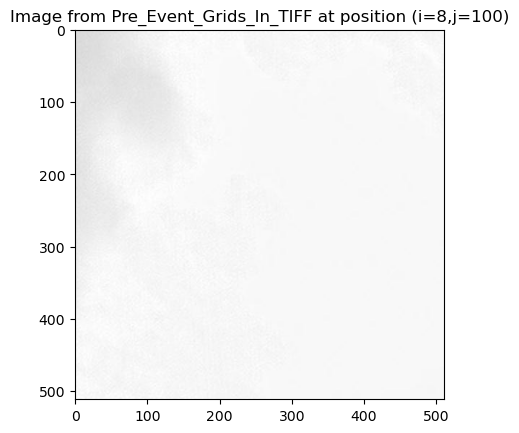

In [44]:
i = 8 
j = 100

load_and_visualize(f"Pre_Event_Grids_In_TIFF/tile_{i}_{j}.tif")

In [45]:
import shapely.geometry
import rasterio.features 

def extract_coor_from_tiff_image(path):
  """
  extract coordinates associated to a tif image
  """
  with rasterio.open(path) as dataset:

    # Read the dataset's valid data mask as a ndarray.

    mask = dataset.dataset_mask()

    # Extract feature shapes and values from the array.
    for geom, val in rasterio.features.shapes(
            mask, transform=dataset.transform):
        
        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(
            dataset.crs, 'EPSG:4326', geom, precision=6)

        bounds = shapely.geometry.shape(geom).bounds
        #minx, miny, maxx, maxy = bounds
        bounds = [[bounds[1], bounds[0]], [bounds[3], bounds[2]]]
        #[[18.461885, -66.190829], [18.463317, -66.189328]]

        return geom, bounds # return a geojson object (polygon localized on a map)
        #bounds are folium compatible

def convert_tiff_to_numpy(tif_path):
    # check if output_dir exists, if not create it
    # check if file is an image (ends with .tif)
    with rasterio.open(tif_path)as src:
          image_array = src.read([1, 2, 3])  # Read bands 1, 2, and 3 in a single call
          # Transpose the array for correct display (optional)
          image_array = image_array.transpose(1, 2, 0)
          return image_array    

import multiprocessing as mp
from joblib import Parallel, delayed

def process_tif(path):
    geom , bounds = extract_coor_from_tiff_image(path)
    geom = Polygon(geom["coordinates"][0])
    return [path, geom]

def table_tiff_geojson_fast(folder_tiff):
    """
    create a geo dataframe from a tiff folder
    """
    if os.path.exists(folder_tiff):
        list_tifs = glob.glob(folder_tiff + "/*.tif")
        gdf = gpd.GeoDataFrame(columns=["path", "geometry"], index=range(len(list_tifs)))

        num_cores = mp.cpu_count()  # Number of cores in your machine
        print("number of cores : ", num_cores)
        results = Parallel(n_jobs=num_cores)(delayed(process_tif)(path) for path in list_tifs)

        for i, result in enumerate(results):
            gdf.loc[i] = result

        print(f"{folder_tiff} has been converted into GeoJSON DataFrame")
        return gdf

In [46]:
%%time
"""folder_tiff = "Post_Event_Grids_In_TIFF"
table_tiff_post = table_tiff_geojson_fast(folder_tiff)
"""
folder_tiff = "Pre_Event_Grids_In_TIFF"
table_tiff_pre = table_tiff_geojson_fast(folder_tiff)

number of cores :  72


Pre_Event_Grids_In_TIFF has been converted into GeoJSON DataFrame
CPU times: user 18 s, sys: 2.38 s, total: 20.4 s
Wall time: 21.4 s


In [47]:
#qurey points are the centroids of the footprint building gdf["centroids"]
from sklearn.neighbors import KDTree
import time 
from shapely import Point
#find the images where foot prints appears

def matching_footprint_to_tiff_images(ft_gdf, table_tiff):
      """
      Matching footprints with tiff images (by using centroids)
      """
      t0 = time.time()
      required_cols = ["geometry"]
      if not all(col in ft_gdf.columns for col in required_cols):
        raise ValueError("Missing required columns in ft_gdf.")
      if not all(col in table_tiff.columns for col in required_cols):
        raise ValueError("Missing required columns in table_tiff.")

      # to compute distance btw these 2 figures they need to be put into the same geodesic referential system (GPS : lat, long)
      ft_gdf = ft_gdf.set_crs('epsg:4326') #Geodesic coordinate
      table_tiff = table_tiff.set_crs('epsg:4326')

      #to use euclidian distance
      ft_gdf = ft_gdf.to_crs('EPSG:3857') #EPSG:3857 Projected coordinate Mercator (Map)
      table_tiff = table_tiff.to_crs('EPSG:3857')

      centroid_query = np.array(list(zip(ft_gdf.centroid.x.to_numpy() , ft_gdf.centroid.y.to_numpy())))
      centroid_table = np.array(list(zip(table_tiff.centroid.x.to_numpy() , table_tiff.centroid.y.to_numpy())))

      print("creation of the KD Tree for tile centroid")
      print("number of footprints : ", len(centroid_query))
      print("number of titles : ", len(centroid_table))
        
      tree = KDTree(centroid_table, leaf_size = 20, metric='euclidean')

      print("query the Tree with the centroid of the footprints")
      distances, indices = tree.query(centroid_query, k=1) #each footprint centroid find its tile by finding the nearest tile centroid
      response = [str(table_tiff.iloc[i]["path"]) for i in indices.squeeze(1)]
      tile_centroids = [Point(centroid_table[i]) for i in indices.squeeze(1)]

      df = {}

      ft_gdf = ft_gdf.to_crs('epsg:4326')
      df["path_to_image"] = pd.Series(response) # associated images 
      df["distance"] = pd.Series(distances[:,0]) #in meters
      df["geometry"] = ft_gdf["geometry"].reset_index(drop=True) #associated footprints 
      df["centroid_tile"] = gpd.GeoSeries(tile_centroids, crs='EPSG:3857').to_crs('epsg:4326')
        
      print("processing time : ", time.time() - t0, "s")
      return gpd.GeoDataFrame(df)

In [49]:
#matching_table_post = matching_footprint_to_tiff_images(gdf, table_tiff_post)
matching_table_pre = matching_footprint_to_tiff_images(gdf, table_tiff_pre)

creation of the KD Tree for tile centroid
number of footprints :  281572
number of titles :  10730
query the Tree with the centroid of the footprints


processing time :  13.43380618095398 s


In [50]:
#matching_table_post.head()
matching_table_pre.head()

,path_to_image,distance,geometry,centroid_tile
0,Pre_Event_Grids_In_TIFF/tile_29_21.tif,99.512477,"POLYGON ((-66.14690 18.44855, -66.14693 18.448...",POINT (-66.14742 18.44927)
1,Pre_Event_Grids_In_TIFF/tile_6_48.tif,60.051077,"POLYGON ((-66.18244 18.41134, -66.18255 18.411...",POINT (-66.18204 18.41169)
2,Pre_Event_Grids_In_TIFF/tile_16_35.tif,86.463854,"POLYGON ((-66.16759 18.42941, -66.16762 18.429...",POINT (-66.16696 18.42981)
3,Pre_Event_Grids_In_TIFF/tile_49_76.tif,72.305978,"POLYGON ((-66.11981 18.37107, -66.11986 18.371...",POINT (-66.11916 18.37125)
4,Pre_Event_Grids_In_TIFF/tile_12_43.tif,60.717674,"POLYGON ((-66.17243 18.41846, -66.17257 18.418...",POINT (-66.17306 18.41861)


In [51]:
len(matching_table_pre)

281572

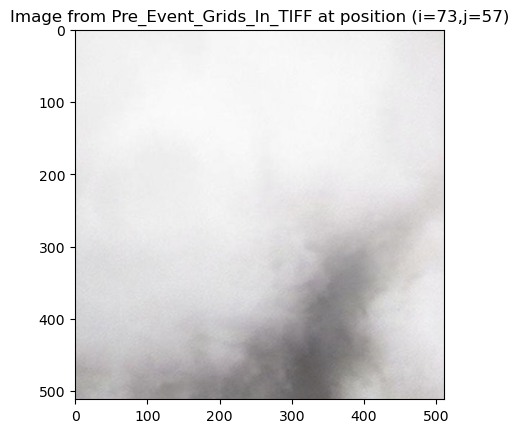

In [52]:
load_and_visualize(f"Pre_Event_Grids_In_TIFF/tile_73_57.tif")

In [53]:
def calculate_distance_from_tiff(path):
    with rasterio.open(path) as dataset:
        # Get pixel resolution (size of each pixel)
        x_resolution, y_resolution = dataset.res

        # Get image dimensions (number of pixels in each dimension)
        width = dataset.width
        height = dataset.height

        # Calculate distance covered in each dimension
        distance_x = width * x_resolution
        distance_y = height * y_resolution

        return distance_x, distance_y

def data_gathering(data):
    """
    from a filtered dataset with pair (image, footprint) convert the images into array
    """
    list_path = data.path_to_image.unique()
    res = {}
    for path in tqdm(list_path):
         output = data[data["path_to_image"] == path]
         res[path] = output.geometry.array
    return res

In [16]:
#filter : 
matching_table_post_filtered = matching_table_post[matching_table_post["distance"] <= 106]
results_post = data_gathering(matching_table_post_filtered)

100%|██████████| 7697/7697 [02:05<00:00, 61.44it/s]


In [54]:
#filter : 
matching_table_pre_filtered = matching_table_pre[matching_table_pre["distance"] <= 106]
results_pre = data_gathering(matching_table_pre_filtered)

100%|██████████| 7697/7697 [01:37<00:00, 79.27it/s]


In [55]:
def convert_tiff_to_jpeg(input_dir, output_dir):
    """
    Converting tiff images to jpeg images.
    """
    # check if output_dir exists, if not create it
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        # check if file is an image (ends with .tif)
        if filename.endswith('.tif'):
            img = Image.open(os.path.join(input_dir, filename))
        
            # check if image is RGB mode, if not convert it
            if img.mode != 'RGB':
                img = img.convert('RGB')
        
            # create new filename, replace .tif with .jpg
            output_filename = os.path.splitext(filename)[0] + '.jpg'
        
            # save the image in JPEG format
            img.save(os.path.join(output_dir, output_filename), 'JPEG', quality=100)
    print("Conversion from TIFF to JPEG completed.")

Pre_Event_Grids_In_TIFF/tile_36_109.tif  :  <GeometryArray>
[<POLYGON ((-66.139 18.324, -66.139 18.324, -66.139 18.325, -66.139 18.325, -...>,
 <POLYGON ((-66.139 18.325, -66.139 18.324, -66.139 18.325, -66.139 18.325, -...>,
 <POLYGON ((-66.138 18.324, -66.138 18.324, -66.139 18.324, -66.138 18.324, -...>,
 <POLYGON ((-66.14 18.324, -66.14 18.324, -66.14 18.325, -66.14 18.325, -66.1...>,
 <POLYGON ((-66.138 18.325, -66.139 18.325, -66.139 18.325, -66.138 18.325, -...>,
 <POLYGON ((-66.139 18.325, -66.139 18.325, -66.139 18.325, -66.139 18.325, -...>,
 <POLYGON ((-66.139 18.325, -66.139 18.325, -66.139 18.325, -66.139 18.325, -...>,
 <POLYGON ((-66.139 18.326, -66.139 18.326, -66.139 18.326, -66.139 18.326, -...>,
 <POLYGON ((-66.139 18.325, -66.139 18.325, -66.139 18.325, -66.139 18.326, -...>,
 <POLYGON ((-66.139 18.325, -66.139 18.325, -66.139 18.325, -66.139 18.325, -...>,
 <POLYGON ((-66.139 18.325, -66.139 18.325, -66.139 18.325, -66.139 18.326, -...>,
 <POLYGON ((-66.14 18.325, 

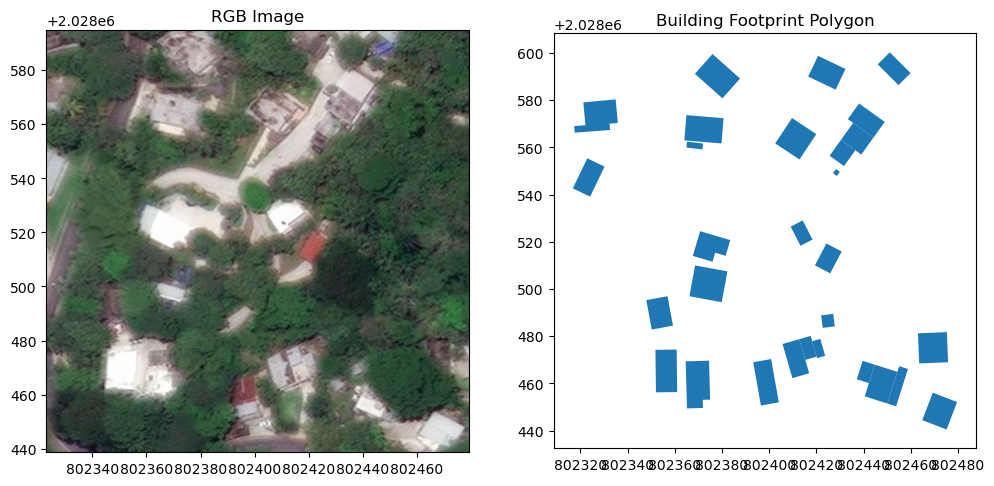

In [57]:
from rasterio.mask import mask
from rasterio.plot import show
import geopandas as gdp

#image_path = np.random.choice(list(results_post.keys()))
image_path = "Pre_Event_Grids_In_TIFF/tile_36_109.tif" 
info = results_pre[image_path] #extract the associated building footprint
print(image_path , " : ", info)

with rasterio.open(image_path) as src:
        # Get the CRS (Coordinate Reference System) of the TIFF image
        crs = src.crs
        polygons = gdp.GeoDataFrame(geometry = info) 
        polygons = polygons.to_crs(crs)
        # Create subplot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

        # Plot RGB image
        show(src, ax=ax1)
        ax1.set_title('RGB Image')
        
        # Plot building footprint
        polygons.plot(ax=ax2)
        ax2.set_title('Building Footprint Polygon')

        plt.show()

### Display RGB image with Building Footprint

[[18.324274, -66.139879], [18.325706, -66.138379]]



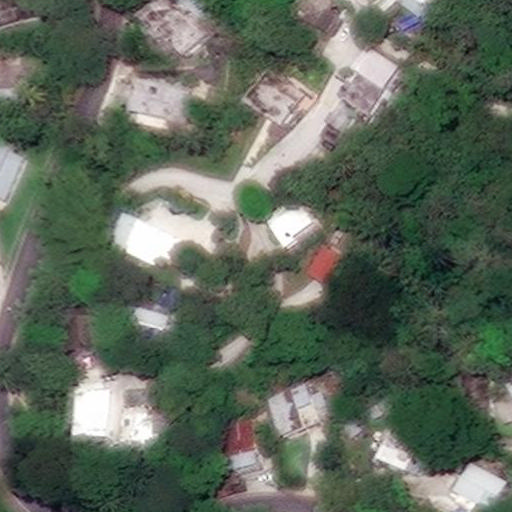

In [58]:
geom , bounds = extract_coor_from_tiff_image(image_path)
print(bounds)
polygons_ = info

# Filter out empty or missing polygons
valid_polygons = [polygon for polygon in polygons_ if not polygon.is_empty]

# Create the map
m = folium.Map(location=bounds[0], zoom_start=15)

# Add valid polygons to the map
bbox = folium.GeoJson(
    data={"type": "FeatureCollection", "features": [
        {"type": "Feature", "geometry": shapely.geometry.mapping(polygon)} for polygon in valid_polygons
    ]},
    style_function=lambda x: {'color': 'blue'}
).add_to(m)

# Add the image overlay
img = folium.raster_layers.ImageOverlay(
    name="pre event Puerto Rico",
    bounds=bounds,
    image=convert_tiff_to_numpy(image_path),
    opacity=1,
    cross_origin=False,
    zindex=1
).add_to(m)

# Add a popup
folium.Popup("pre event Puerto Rico").add_to(m)

# Show the map
m


In [59]:
from shapely.ops import cascaded_union
from rasterio.plot import reshape_as_image
from rasterio import features
import re 

def poly_from_utm(polygon, transform):
    """
    Convert polygon coordinates from UTM to image pixel coordinates.
    """
    poly_pts = []
    for x, y in np.array(polygon.exterior.coords):
        x, y = ~transform * (x, y)
        poly_pts.append((x, y))
    return Polygon(poly_pts)

    
def generate_mask(image_path, shapes, save_path_o):
    """
    image_path : string 
    shapes : list of polygones associated to image_path 
    """ 
    #create a directory
    if not os.path.exists(save_path_o):
        os.makedirs(save_path_o)

    #if the associated file already exist do not generate the mask 
    delimiters = "/. "
    save_path = save_path_o + "/" + re.split('[{}]+'.format(''.join(map(re.escape, delimiters))), image_path)[1] + "_mask.tif"
    if not os.path.exists(save_path):

        with rasterio.open(image_path, "r") as src: #read tiff image

            raster_image = src.read()
            raster_meta = src.meta
            crs_image = raster_meta["crs"]

        train_df = gpd.GeoDataFrame(geometry = shapes).to_crs(crs_image) #create a geo pandas with the footprints 

        poly_shp = []
        im_size = (src.meta['height'], src.meta['width'])
        for num, row in train_df.iterrows():
            if row['geometry'].geom_type == 'Polygon':
                poly = poly_from_utm(row['geometry'], src.meta['transform'])
                poly_shp.append((poly, num))
            elif row['geometry'].geom_type == 'MultiPolygon':
                multipolygon = row['geometry'].geoms
                for p in multipolygon: 
                    poly = poly_from_utm(p, src.meta['transform']) 
                    poly_shp.append((poly, num))
            else:
                print(f"Unsupported geometry type: {row['geometry'].geom_type}")

        #create a mask from the footprint
        mask = features.rasterize(shapes=poly_shp,
                                out_shape=im_size, 
                                fill=-1)
        
        mask = mask.astype("uint16")
        bin_mask_meta = src.meta.copy()
        bin_mask_meta.update({'count': 1})
        with rasterio.open(save_path, 'w', **bin_mask_meta) as dst:
            dst.write(mask * 255, 1)

In [60]:
%%time
def convert_tiff_images_to_jpeg(image_paths_tiff, output_dir="Pre_Event_Grids_In_jpeg"):
    # check if output_dir exists, if not create it
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in tqdm(image_paths_tiff):
        # check if file is an image (ends with .tif)
        if filename.endswith('.tif'):
            img = Image.open(os.path.join(filename))
        
            # check if image is RGB mode, if not convert it
            if img.mode != 'RGB':
                img = img.convert('RGB')
        
            # create new filename, replace .tif with .jpg
            delimiters = "/. "
            output_filename = re.split('[{}]+'.format(''.join(map(re.escape, delimiters))), filename)[1] + '.jpg'
        
            # save the image in JPEG format
            img.save(os.path.join(output_dir, output_filename), 'JPEG', quality=100)
    print("Conversion from TIFF to JPEG completed.")

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 20.5 µs


In [61]:
#convert_tiff_images_to_jpeg(results_post.keys(),"Post_Event_Grids_In_jpeg") 
convert_tiff_images_to_jpeg(results_pre.keys(),"Pre_Event_Grids_In_jpeg") 

100%|██████████| 7697/7697 [00:47<00:00, 162.36it/s]

Conversion from TIFF to JPEG completed.


In [39]:
%%time 
save_path_o = "Post_Event_Grids_In_TIFF_mask"

for image_path in tqdm(results_post.keys()):
    generate_mask(image_path, results_post[image_path], save_path_o)

100%|██████████| 7697/7697 [06:55<00:00, 18.51it/s]

CPU times: user 6min 27s, sys: 28.5 s, total: 6min 55s
Wall time: 6min 55s


In [62]:
%%time 
save_path_o = "Pre_Event_Grids_In_TIFF_mask"
for image_path in tqdm(results_pre.keys()):
    generate_mask(image_path, results_pre[image_path], save_path_o)

100%|██████████| 7697/7697 [02:11<00:00, 58.50it/s] 

CPU times: user 2min, sys: 10.3 s, total: 2min 10s
Wall time: 2min 11s


In [41]:
mask_paths = glob.glob("Post_Event_Grids_In_TIFF_mask/*.tif")
convert_tiff_images_to_jpeg(mask_paths ,output_dir="Post_Event_Grids_mask_jpeg")

 59%|█████▊    | 4511/7697 [00:11<00:07, 421.84it/s]

100%|██████████| 7697/7697 [00:18<00:00, 406.04it/s]

Conversion from TIFF to JPEG completed.


In [63]:
mask_paths = glob.glob("Pre_Event_Grids_In_TIFF_mask/*.tif")
convert_tiff_images_to_jpeg(mask_paths ,output_dir="Pre_Event_Grids_mask_jpeg") 

100%|██████████| 7720/7720 [00:17<00:00, 447.43it/s]

Conversion from TIFF to JPEG completed.
